In [121]:
import scipy.io
import matplotlib.pyplot as plt
from datasets import LaserDataset
from models import MLP
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [99]:
Xtrain = scipy.io.loadmat('../data/Xtrain.mat')
Xtrain = Xtrain['Xtrain']

Xval = Xtrain[800:]
Xtrain = Xtrain[:800]

Xtest = scipy.io.loadmat('../data/Xtest.mat')
Xtest = Xtest['Xtest']

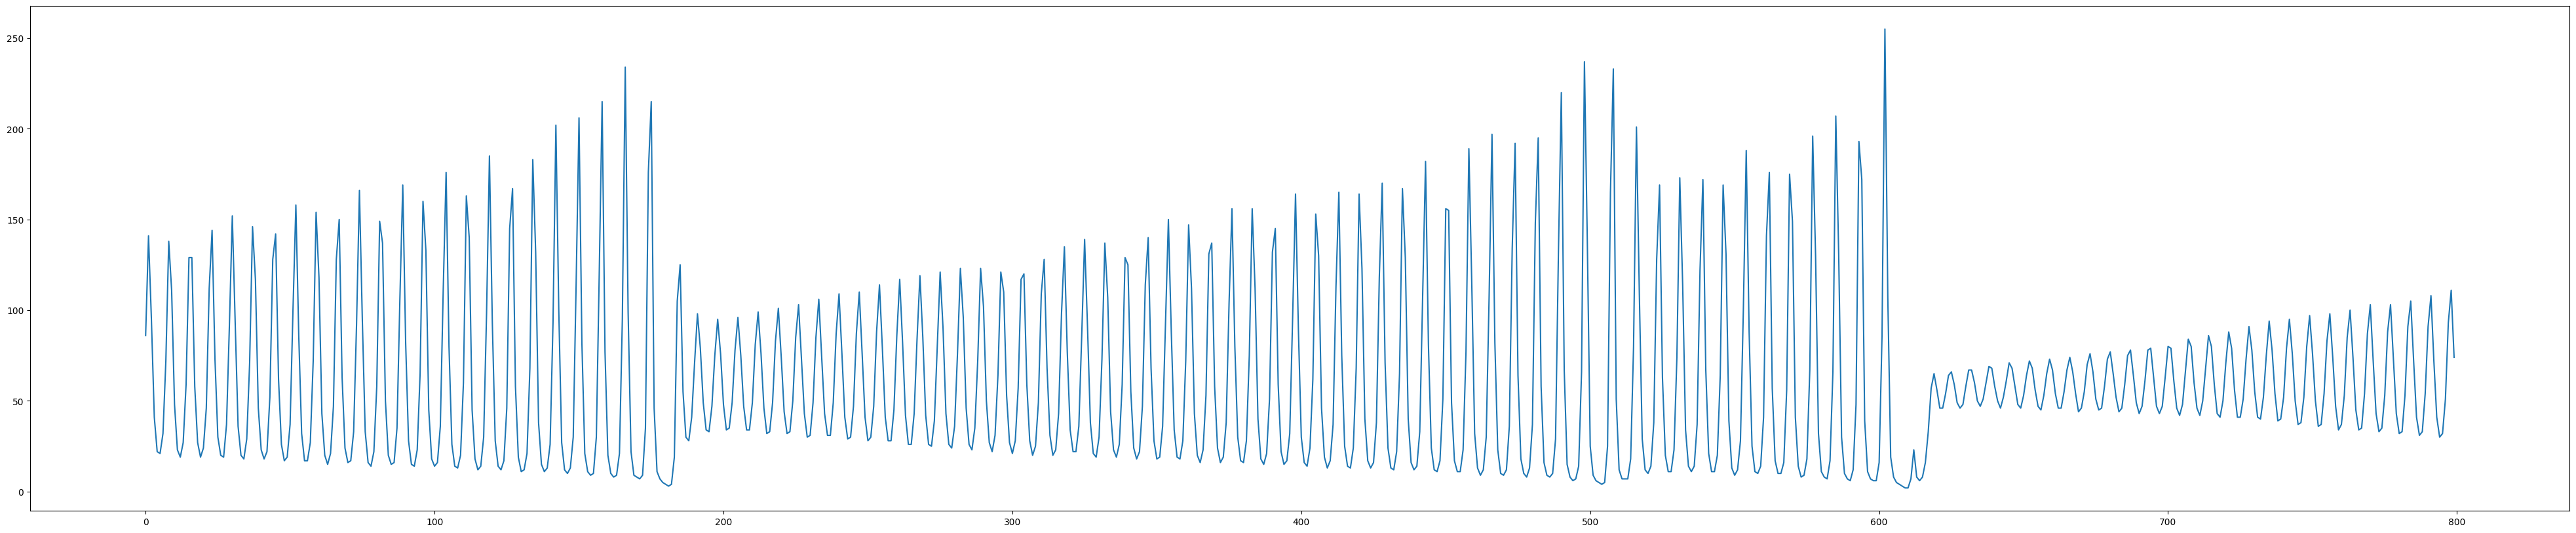

In [101]:
plt.figure(figsize=(50,10))
plt.plot(Xtrain)

In [107]:
window_size = 20

dataset = LaserDataset(Xtrain, window_size)
dataset_val = LaserDataset(Xval, window_size)

X_list, y_list = [], []
for X, y in dataset:
    X_list.append(X.numpy())
    y_list.append(y.item())

X_np = np.array(X_list)
y_np = np.array(y_list)

X_list, y_list = [], []
for X, y in dataset_val:
    X_list.append(X.numpy())
    y_list.append(y.item())

X_np_val = np.array(X_list)
y_np_val = np.array(y_list)

In [ ]:
# Normalizing
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_np)
X_scaled_val = scaler_X.transform(X_np_val)
y_scaled = scaler_y.fit_transform(y_np.reshape(-1, 1)).ravel()

# SVR
model = SVR(kernel='rbf', C=100.0, epsilon=0.01, gamma='auto')
model.fit(X_scaled, y_scaled)

# Prediction on whole dataset
pred_scaled = model.predict(X_scaled_val)
pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

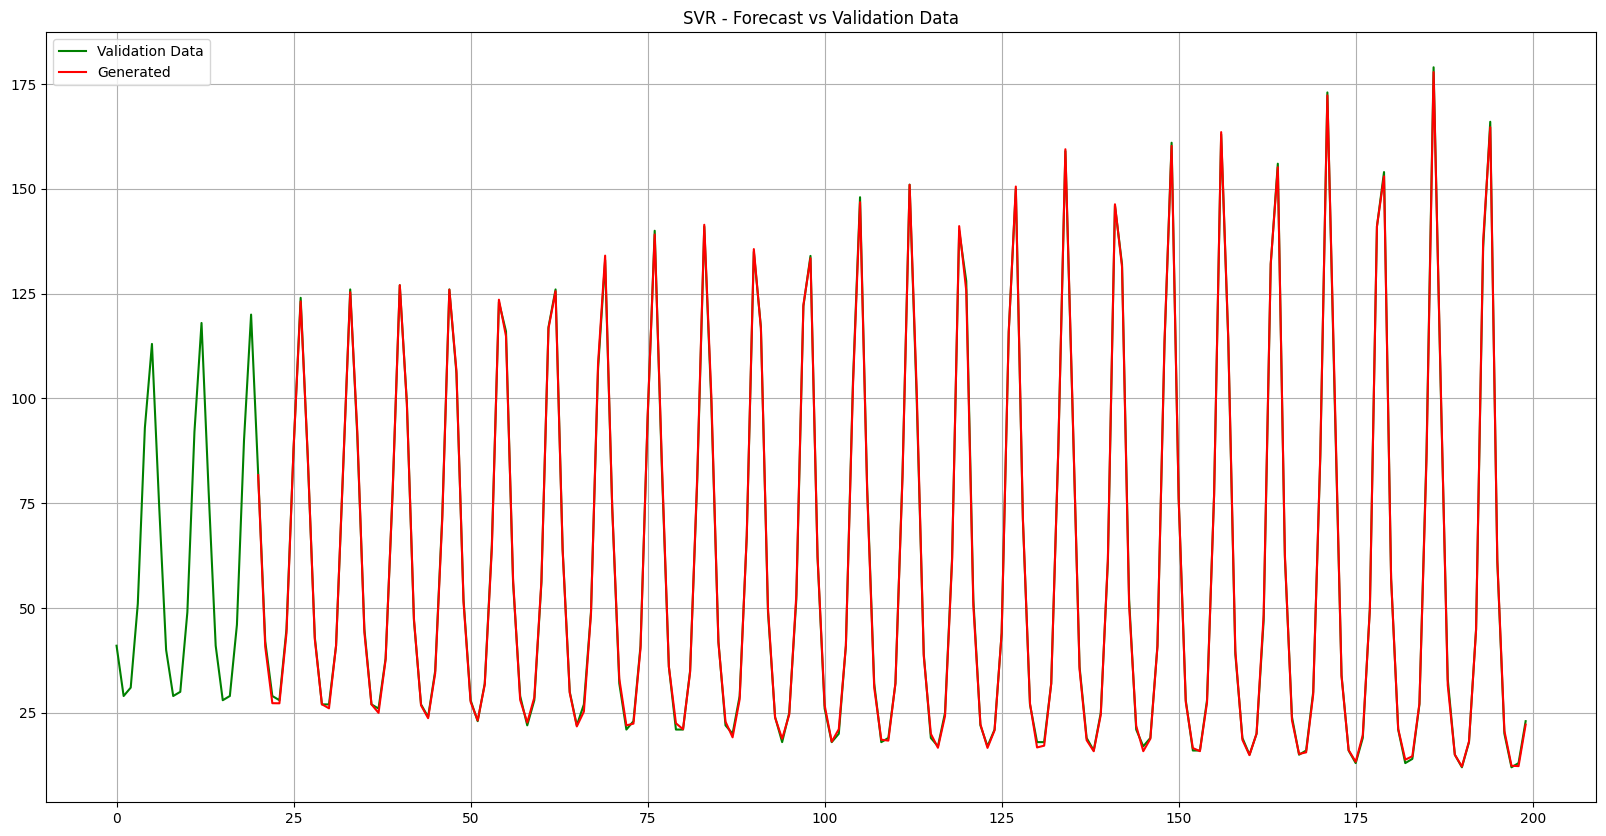

In [115]:
plt.figure(figsize=(20, 10))
plt.plot(Xval, label="Validation Data", color='green')
plt.plot(range(20, 20+len(pred)), pred, label="Generated", color='red')
plt.legend()
plt.title(f"SVR - Forecast vs Validation Data")
plt.grid(True)
plt.show()

In [ ]:
def recursive_forecast(model, data, window_size, forecast_horizon=200, scaler_X=None, scaler_y=None):
    """
    Rekurencyjna prognoza z użyciem modelu regresyjnego (np. SVR).
    """
    forecast = []
    current_window = data[-window_size:].copy()

    for _ in range(forecast_horizon):
        X_input = current_window.reshape(1, -1)
        
        if scaler_X:
            X_input = scaler_X.transform(X_input)

        y_pred_scaled = model.predict(X_input)

        if scaler_y:
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()[0]
        else:
            y_pred = y_pred_scaled[0]

        forecast.append(y_pred)

        current_window = np.roll(current_window, -1)
        current_window[-1] = y_pred

    return np.array(forecast)


In [117]:
forecast = recursive_forecast(model, Xtrain, window_size, scaler_X=scaler_X, scaler_y=scaler_y)

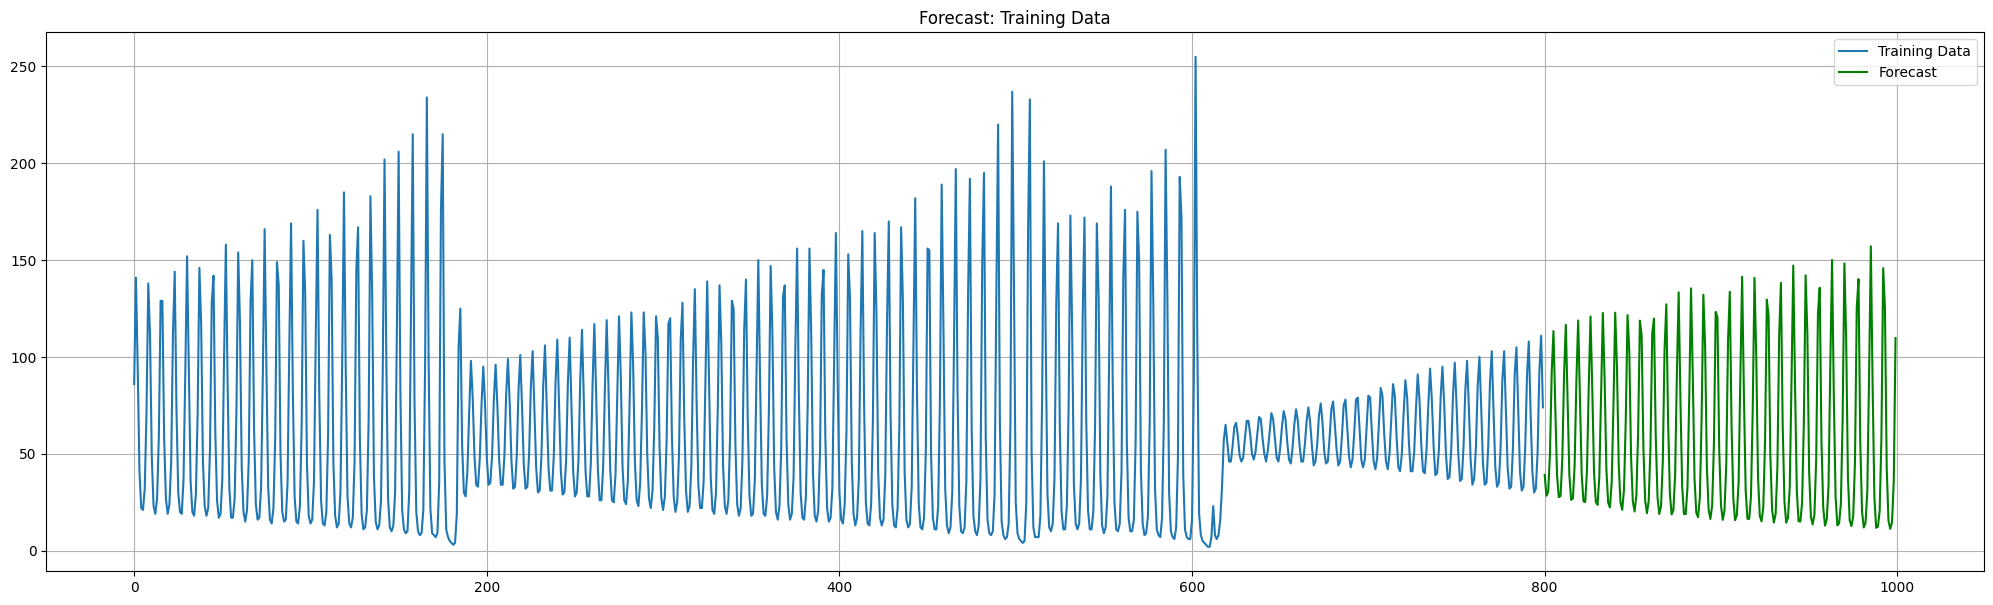

In [118]:
plt.figure(figsize=(25, 7))
plt.plot(Xtrain, label="Training Data")
# plt.plot(pred, label="Generated", color='red')
plt.plot(range(len(Xtrain), len(Xtrain) + 200), forecast, label="Forecast", color='green')

plt.legend()
plt.title(f"Forecast: Training Data")
plt.grid(True)
plt.show()

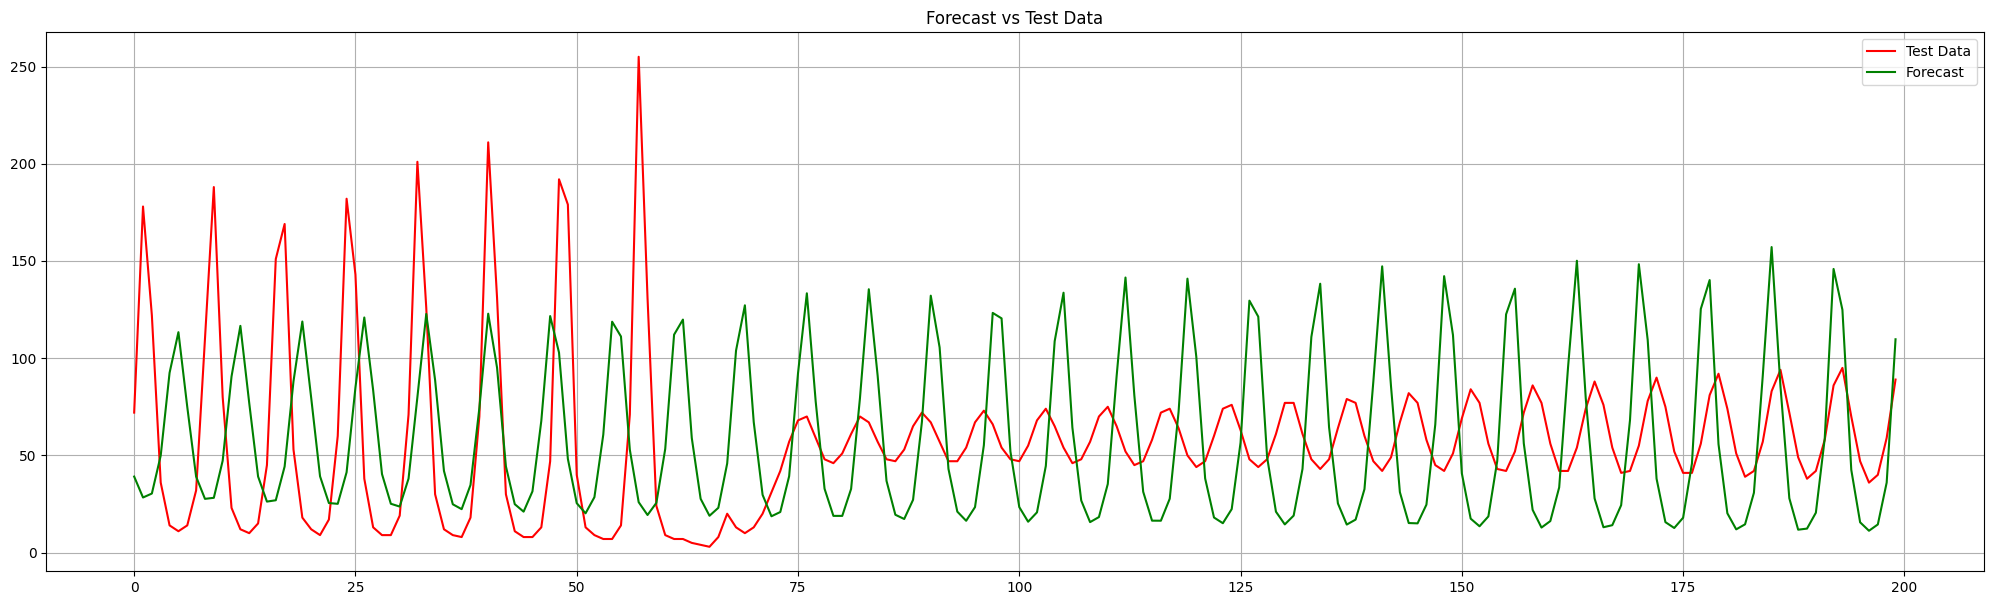

In [119]:
plt.figure(figsize=(25, 7))
plt.plot(Xtest, label="Test Data", color = 'red')
plt.plot(forecast, label="Forecast", color='green')

plt.legend()
plt.title(f"Forecast vs Test Data")
plt.grid(True)
plt.show()

In [ ]:
# gridsearech

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid = {
    'svr__kernel': ['rbf', 'linear', 'poly'],
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto']
}

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_np, y_np)

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy MSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=linear; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=linear; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=linear; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.01, svr__gamma=scale, svr__kernel=linear; tot

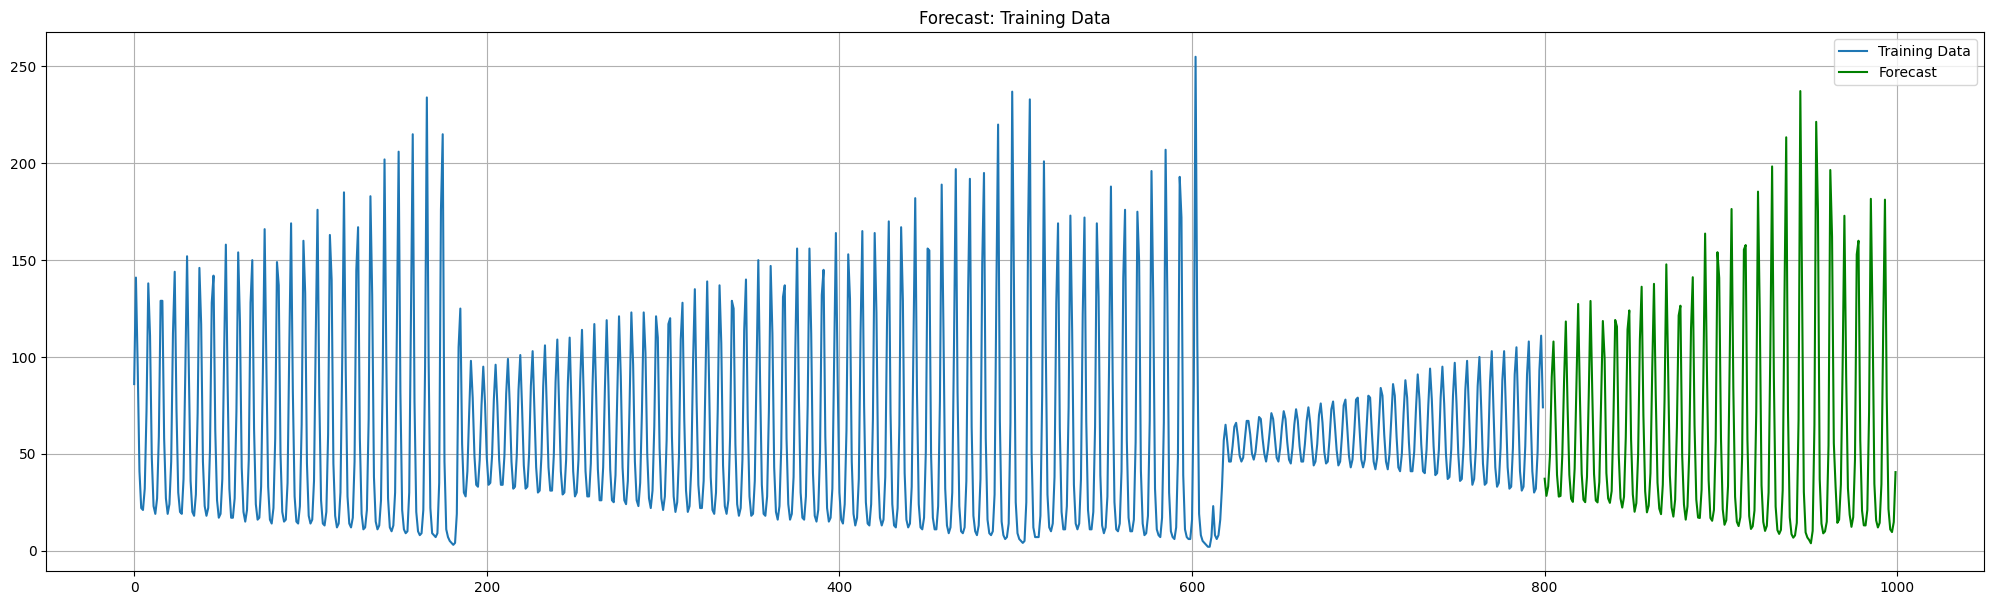

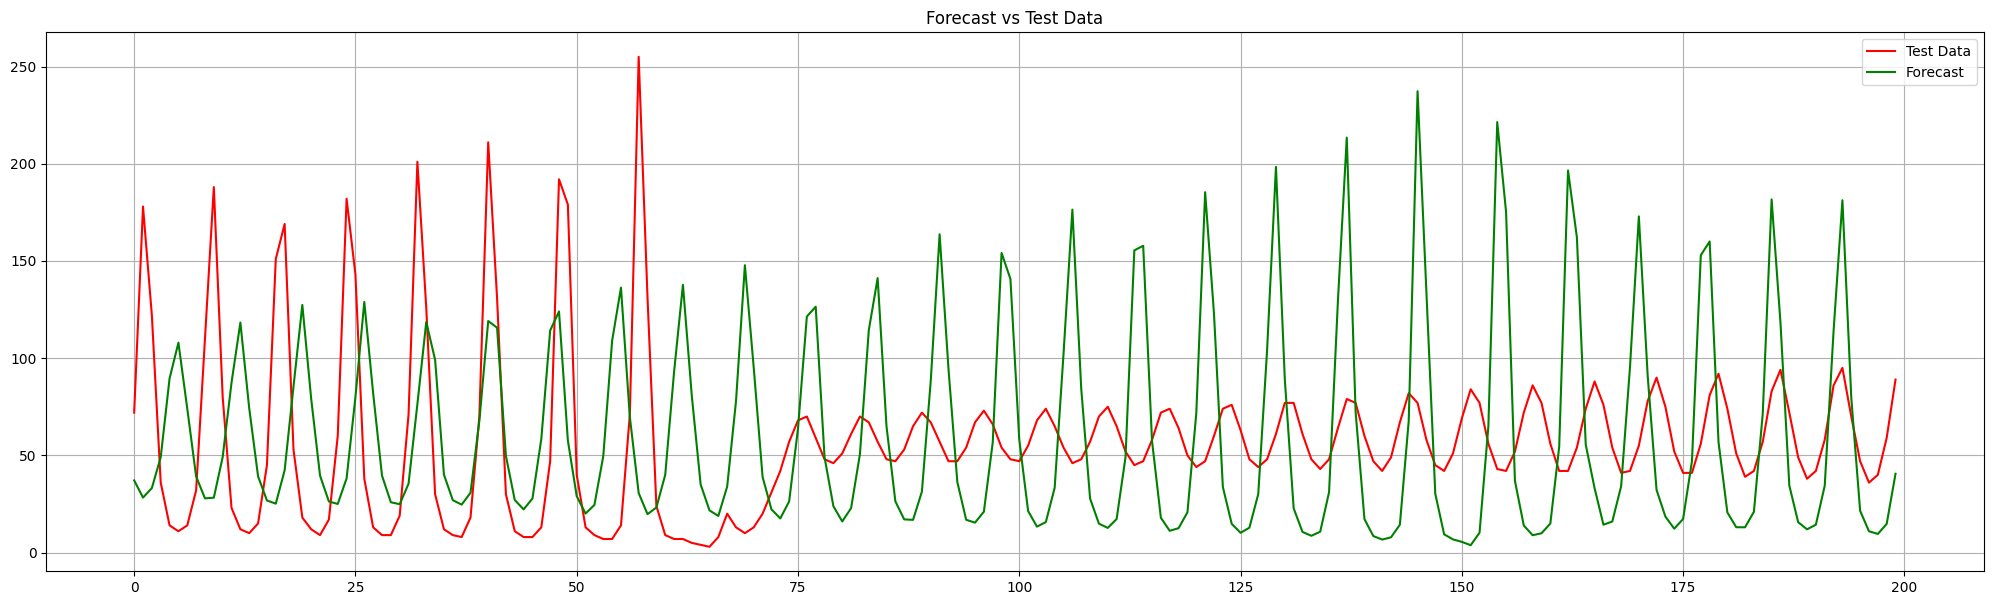

MSE: 4407.03125
MAE: 52.224971771240234


In [ ]:
chosen_model = model

forecast = recursive_forecast(chosen_model, Xtrain, window_size, scaler_X=scaler_X, scaler_y=scaler_y)

plt.figure(figsize=(25, 7))
plt.plot(Xtrain, label="Training Data")
plt.plot(range(len(Xtrain), len(Xtrain) + 200), forecast, label="Forecast", color='green')
plt.legend()
plt.title(f"Forecast: Training Data")
plt.grid(True)
plt.show()

plt.figure(figsize=(25, 7))
plt.plot(Xtest, label="Test Data", color = 'red')
plt.plot(forecast, label="Forecast", color='green')
plt.legend()
plt.title(f"Forecast vs Test Data")
plt.grid(True)
plt.show()

mse = mean_squared_error(Xtest, forecast)
mae = mean_absolute_error(Xtest, forecast)
print("MSE:", mse)
print("MAE:", mae)

In [ ]:
# window = 200:
# Najlepsze parametry: {'svr__C': 100, 'svr__epsilon': 0.5, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
# Najlepszy MSE: 1363.0023566275504
# MSE na testowym: 1766.6099299937532

In [ ]:
# window = 20:
# Najlepsze parametry: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
# Najlepszy MSE: 185.54734312325755
# MSE na testowym: 3235.874235098492

In [123]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_idx, val_idx in tscv.split(X_np):
    X_train, X_val = X_np[train_idx], X_np[val_idx]
    y_train, y_val = y_np[train_idx], y_np[val_idx]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        verbosity=0
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    mse_scores.append(mse)

print("XGBoost: Średnie MSE:", np.mean(mse_scores))


XGBoost: Średnie MSE: 341.931702629151


In [124]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Dane: X_np, y_np (np. z LaserDataset)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_np)
y_scaled = scaler_y.fit_transform(y_np.reshape(-1, 1)).ravel()

model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model_xgb.fit(X_scaled, y_scaled)

# Predykcja i denormalizacja
pred_scaled = model_xgb.predict(X_scaled)
pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()